In [1]:
import torch
import torch.nn as nn
# from generate_data import *
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
import statsmodels.api as sm

In [3]:
import h5py

In [6]:
! ls DC_motor_simulation

DC_motor_simulation.prj      diff_eq_system.slxc	  res2.mat   slprj
diff_eq_system.slx	     diff_eq_system.slx.original  res.mat
diff_eq_system.slx.autosave  in.mat			  resources


In [4]:
outfile = h5py.File('DC_motor_simulation/res.mat', 'r')
print(outfile.keys())

<KeysViewHDF5 ['ans']>


In [ ]:
model3=sm.tsa.ARIMA(endog=y[:1000],exog=x[:1000],order=[8,0,1])
results3=model3.fit()
# print(results3.summary())

In [ ]:
pred = results3.predict(start = 20, end=180, exog=x[20:200])

In [ ]:
pred.shape

In [ ]:
plt.plot(pred)
plt.plot(x[:200])
plt.plot(y[:200])

In [ ]:
plt.plot(pred)

In [193]:
data = outfile['ans']

In [7]:
data.shape

(3334, 3)

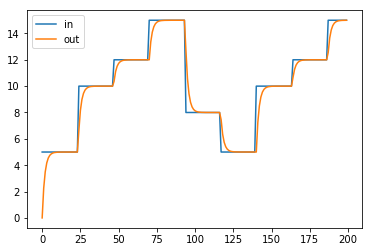

In [8]:
# plt.plot(data[:][:,0], label='time')
# plt.legend()
plt.plot(data[:][:200,1], label='in')
plt.legend()
plt.plot(data[:][:200,2], label='out')
plt.legend()

In [9]:
experiment_timesteps = data.shape[0]

In [10]:
time = data[:][:,0]
x = data[:][:,1]
y = data[:][:,2]

In [74]:
T = [ t for t in np.arange(0, math.pi * 10, math.pi / 100)]
T = T[:experiment_timesteps]
sin_t = [math.sin(t) for t in T]

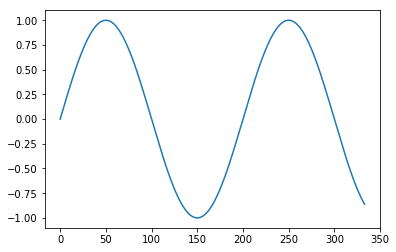

In [76]:
plt.plot(sin_t)

In [77]:
x = np.repeat(x,20, axis = 0)
y = y
# x = np.repeat(T,20, axis = 0)
# y = np.array(sin_t)

In [78]:
x.shape

(6680,)

In [79]:
x = x.reshape([experiment_timesteps, -1])
y = y.reshape([experiment_timesteps, -1])

In [3]:
#####################
# Set parameters
#####################

# Data params
noise_var = 0
num_datapoints = experiment_timesteps
test_size = 0.2
num_train = int((1-test_size) * num_datapoints)

# Network params
input_size = 20
# If `per_element` is True, then LSTM reads in one timestep at a time.
per_element = True
if per_element:
    lstm_input_size = 1
else:
    lstm_input_size = input_size
# size of hidden layers
h1 = 128
output_dim = 1
num_layers = 3
learning_rate = 1e-4
num_epochs = 5000
dtype = torch.float


NameError: name 'experiment_timesteps' is not defined

In [90]:
generate_data = False
#####################
# Generate data
#####################
if generate_data:
    data = ARData(num_datapoints,
                  num_prev=input_size,
                  test_size=test_size, 
                  noise_var=noise_var,
                  coeffs=fixed_ar_coefficients[input_size])

    # make training and test sets in torch
    X_train = torch.from_numpy(data.X_train).type(torch.Tensor)
    X_test = torch.from_numpy(data.X_test).type(torch.Tensor)
    y_train = torch.from_numpy(data.y_train).type(torch.Tensor).view(-1)
    y_test = torch.from_numpy(data.y_test).type(torch.Tensor).view(-1)

    X_train = X_train.view([input_size, -1, 1])
    X_test = X_test.view([input_size, -1, 1])

In [91]:
X_train = torch.from_numpy(x[:num_train, :].T).type(torch.Tensor)
X_test = torch.from_numpy(x[num_train:, :].T).type(torch.Tensor)
X_train = X_train.view([input_size, -1, 1])
X_test = X_test.view([input_size, -1, 1])
y_train = torch.from_numpy(y[:num_train, :]).type(torch.Tensor).view(-1)
y_test = torch.from_numpy(y[num_train:, :]).type(torch.Tensor).view(-1)

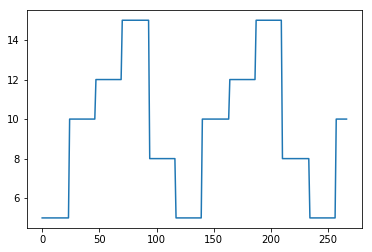

In [92]:
plt.plot(X_train.detach().numpy()[0, :experiment_timesteps])


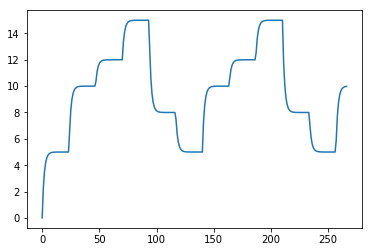

In [93]:
plt.plot(y_train.detach().numpy()[ :experiment_timesteps])

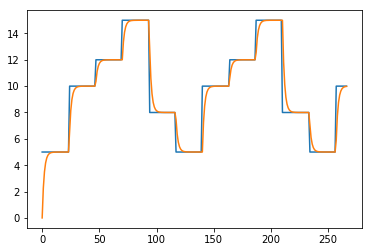

In [94]:
plt.plot(X_train.detach().numpy()[0, :experiment_timesteps])
plt.plot(y_train.detach().numpy()[ :experiment_timesteps])

In [95]:

#####################
# Build model
#####################

# Here we define our model as a class
class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,
                    num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        
        # Only take the output from the final timestep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        return y_pred.view(-1)

model = LSTM(lstm_input_size, h1, batch_size=num_train, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss(size_average=False)

optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)


LSTM(1, 128, num_layers=3)

In [99]:
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(1, 51)
        self.lstm2 = nn.LSTMCell(51, 51)
        self.linear = nn.Linear(51, 1)

    def forward(self, input, future = 0):
        outputs = []
        h_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        h_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [100]:
nn2 = Sequence()

In [101]:
nn2

Sequence(
  (lstm1): LSTMCell(1, 51)
  (lstm2): LSTMCell(51, 51)
  (linear): Linear(in_features=51, out_features=1, bias=True)
)

Epoch  0 MSE:  26972.3203125


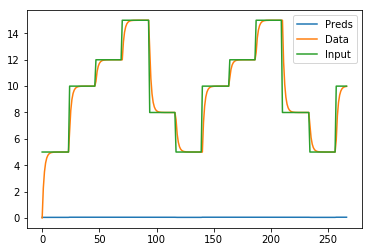

Epoch  100 MSE:  6804.5244140625


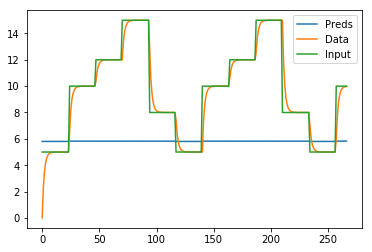

Epoch  200 MSE:  4070.89501953125


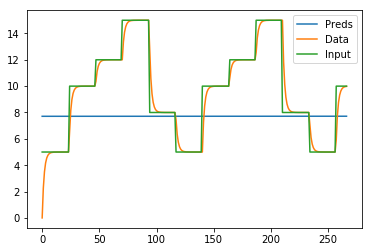

Epoch  300 MSE:  3470.56298828125


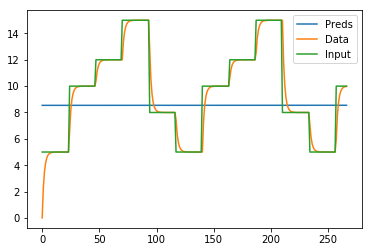

Epoch  400 MSE:  3284.53564453125


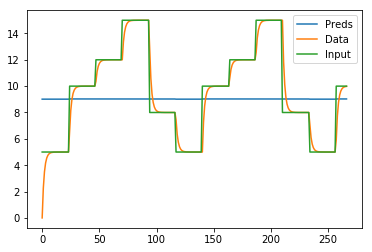

Epoch  500 MSE:  2977.982177734375


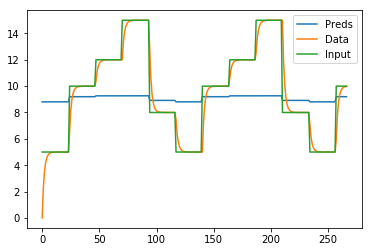

Epoch  600 MSE:  1328.817138671875


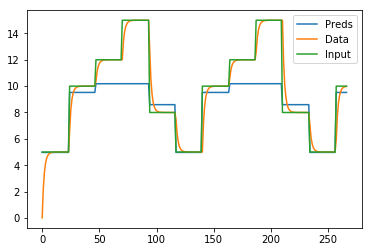

Epoch  700 MSE:  898.8727416992188


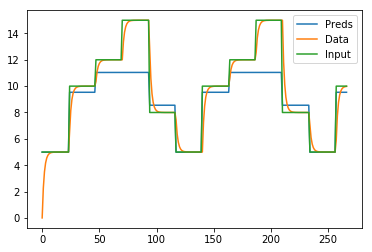

Epoch  800 MSE:  661.887451171875


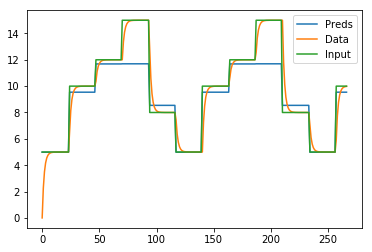

Epoch  900 MSE:  526.7035522460938


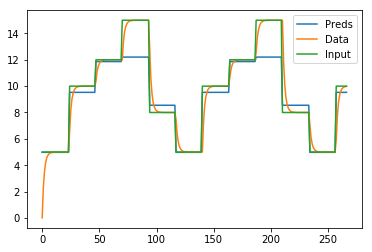

Epoch  1000 MSE:  429.2578430175781


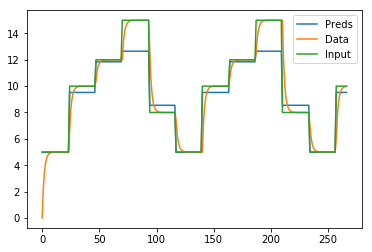

Epoch  1100 MSE:  360.1087951660156


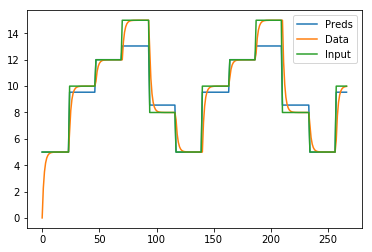

Epoch  1200 MSE:  310.2973937988281


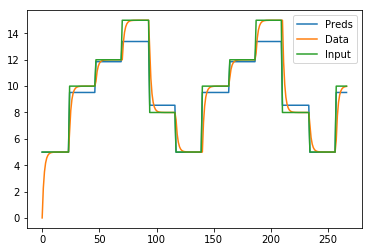

Epoch  1300 MSE:  277.3236083984375


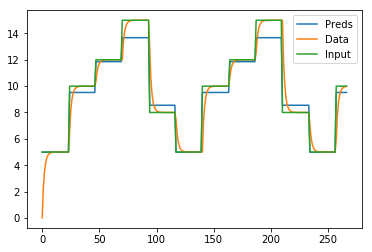

Epoch  1400 MSE:  255.848388671875


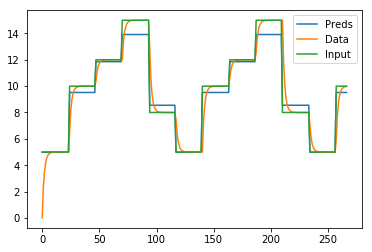

Epoch  1500 MSE:  242.36207580566406


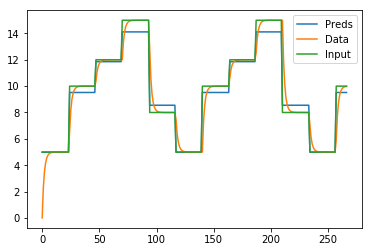

KeyboardInterrupt: 

In [96]:
#####################
# Train model
#####################

hist = np.zeros(num_epochs)

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
#     model.hidden = model.init_hidden()
    
    # Forward pass
    y_pred = model(X_train)

    loss = loss_fn(y_pred, y_train)
    if t % 100 == 0:
        print("Epoch ", t, "MSE: ", loss.item())
        
        plt.plot(y_pred.detach().numpy(), label="Preds")
        plt.plot(y_train.detach().numpy(), label="Data")
        plt.plot(X_train[0].detach().numpy(), label="Input")
        
        plt.legend()
        plt.show()
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()


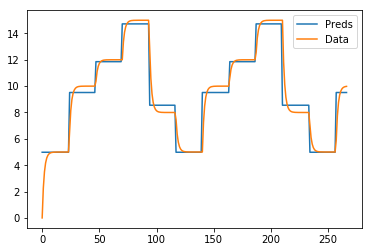

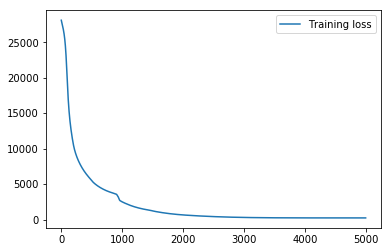

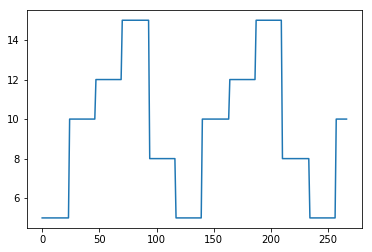

In [88]:

#####################
# Plot preds and performance
#####################
plt.plot(y_pred.detach().numpy(), label="Preds")
plt.plot(y_train.detach().numpy(), label="Data")
plt.legend()
plt.show()

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()
plt.plot(X_train[0, :, -1].detach().numpy(), label="ARG")